In [1]:
using CSV, DataFrames

df = CSV.read("../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells

nothing

In [2]:
function ode(du, u, p, t)
    mum = p[1]
    y = u[1]
    du[1] = mum * y
    return nothing
end

ode (generic function with 1 method)

In [3]:
using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)    
    
    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [N0], p = mum, 
                tspan = (times[1], times[end]), saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

fit_ode (generic function with 2 methods)

In [4]:
using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

log_y_obs = log.(y_obs .+ 1e-9)
model    = fit_ode(log_y_obs, times, prob)
chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 9.99 seconds
Compute duration  = 8.03 seconds
parameters        = mum, N0, sigma
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


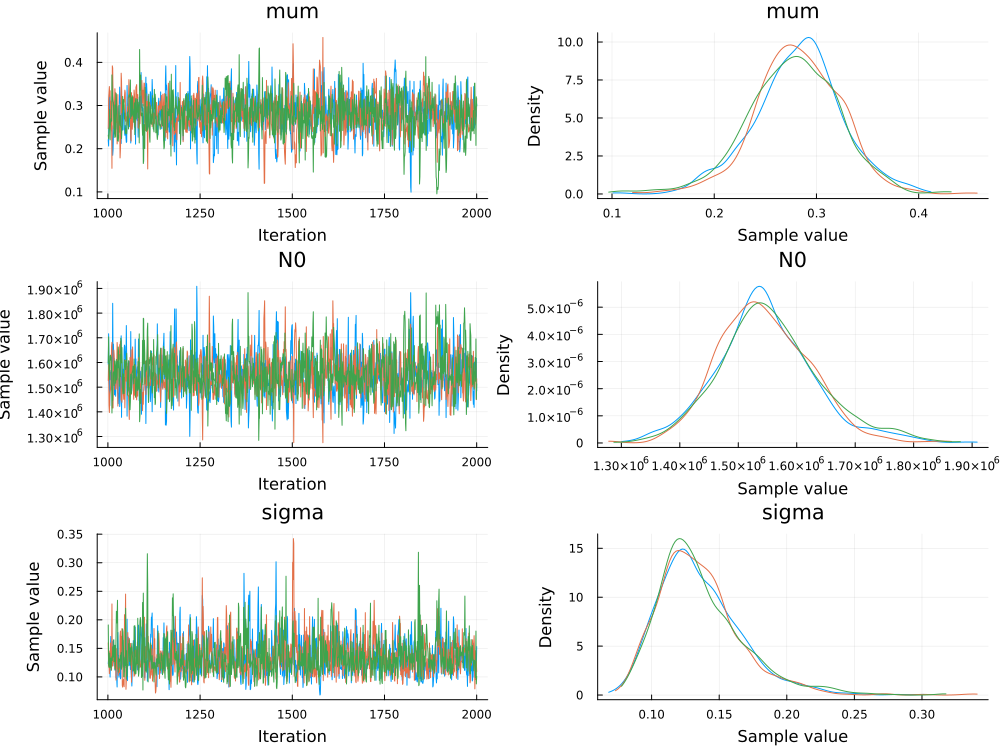

In [5]:
using StatsPlots
#display(chain)
plot(chain)

In [ ]:

using StatsPlots, Distributions, MCMCChains

"""
Plot trace (all chains) + posterior density with prior overlay.

Arguments
- chain  :: Chains
- priors :: Dict{Symbol,Distribution}  e.g., Dict(:mum=>..., :N0=>..., :sigma=>...)

Keywords
- nxs :: Int         # resolution of the prior curve
- per_chain_density  # if true, also draw per-chain densities on the right
"""
function plot_trace_with_priors(chain::Chains;
                                priors::Dict{Symbol,Distribution},
                                nxs::Int=400,
                                per_chain_density::Bool=false)

    ps = collect(keys(priors))
    plt = plot(layout=(length(ps), 2), size=(950, 300*length(ps)))

    for (i, p) in enumerate(ps)
        # --- samples: matrix [iters x nchains] ---
        A = Array(chain[p])                  # each column is a chain
        iters, nch = size(A)

        # --- Left: trace with ALL chains visible ---
        plot!(plt[i, 1], title=String(p), xlabel="Iteration", ylabel="Sample value", legend=:topright)
        for c in 1:nch
            plot!(plt[i, 1], 1:iters, A[:, c], label="chain $c")
        end

        # --- Right: posterior density (all chains combined) ---

        for c in 1:nch
            density!(plt[i, 2], A[:, c], label="chain $c", alpha=0.5)
        end
        
        # --- Prior overlay ---
        prior = priors[p]

        lo = quantile(prior, 0.001)
        hi = quantile(prior, 0.999)

        xs = range(lo, hi; length=nxs)
        plot!(plt[i, 2], xs, pdf.(prior, xs), lw=2, ls=:dash, color=:black, label="Prior")
    end

    plt
end


plot_trace_with_priors

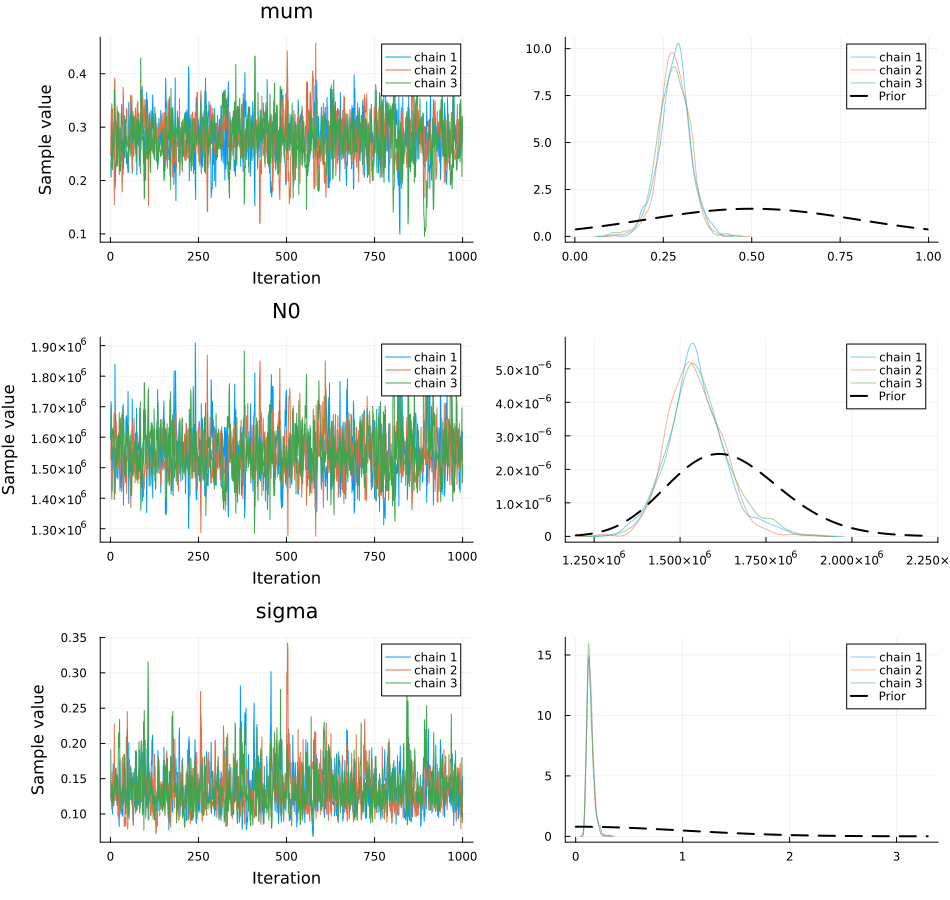

In [9]:
priors = Dict{Symbol,Distribution}(
    :mum   => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :N0    => LogNormal(log(1_630_000.0), 0.1),
    :sigma => truncated(Normal(0, 1.0), 0.0, Inf)
)

#plot_trace_with_priors(chain; priors=priors)                 # combined density + prior
# or:
plot_trace_with_priors(chain; priors=priors, per_chain_density=true)  # also per-chain densities


## Part 2

In [17]:
# from your data-prep cell
using CSV, DataFrames

df = CSV.read("../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells

nothing

In [18]:
function ode(du, u, p, t)
    mum = p[1] 
    delta = p[2]
    y = u[1]
    du[1] = (mum - delta) * y
    return nothing
end

ode (generic function with 1 method)

In [19]:
using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    delta ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)    
    
    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [N0], p = [mum, delta], 
                tspan = (times[1], times[end]), saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

fit_ode (generic function with 2 methods)

In [ ]:
using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5, 0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

log_y_obs = log.(y_obs .+ 1e-9)
model    = fit_ode(log_y_obs, times, prob)
chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)


┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×18×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 6.63 seconds
Compute duration  = 6.58 seconds
parameters        = mum, delta, N0, sigma
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


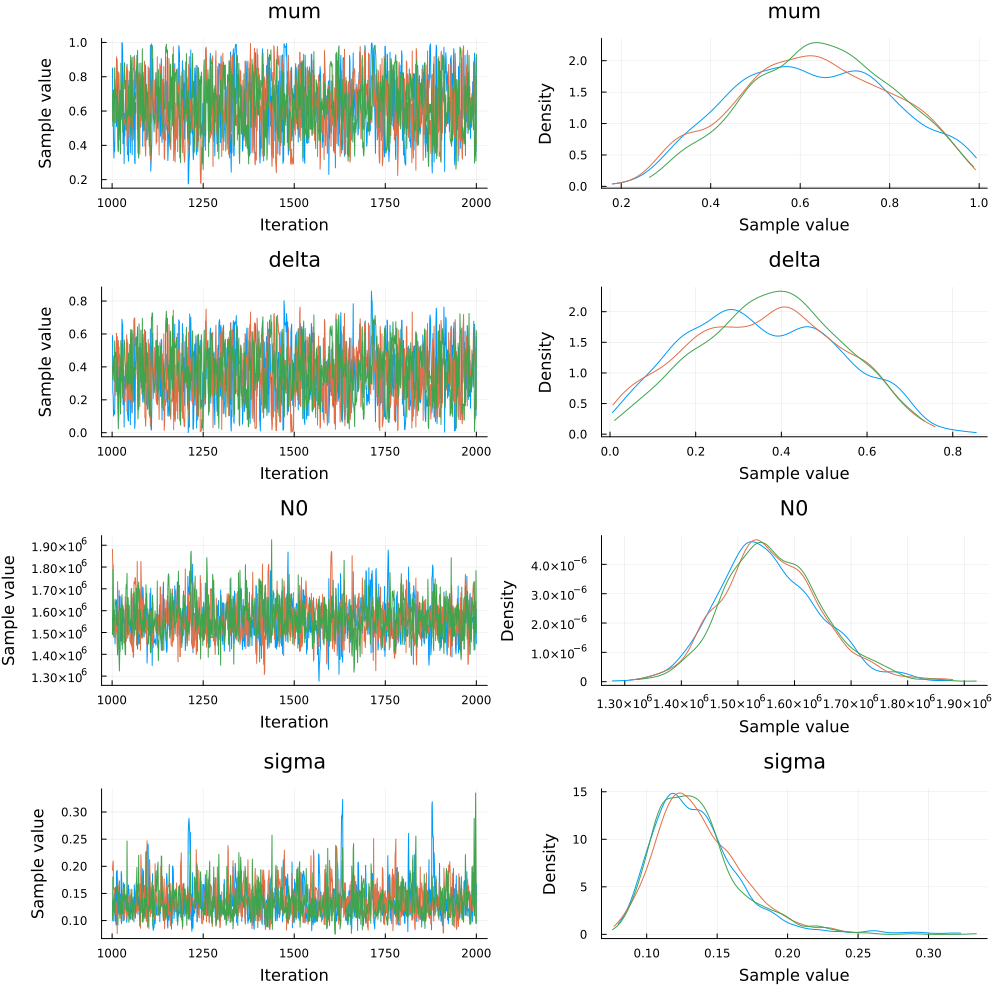

In [ ]:
using StatsPlots
#display(chain)
plot(chain)  # now only parameters (mum, N0, sigma, etc.) 1000, 0.95; max_depth = 15